<a href="https://colab.research.google.com/github/deeppaco/logo_detection_project/blob/main/two_stage_detectors/FasterRCNN_Post_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supporting functions
Load at the beggining 

In [116]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [117]:
def iou_range(x):
  if x<=0:
    return 'IoU = 0'
  elif x<=0.5:
    return 'IoU <0.5'
  else:
    return 'IoU >0.5'

def calculate_area(x):
  try:
    width=x[2]-x[0]
    height=x[3]-x[1]
    return width*height
  except:
    return 0

def return_label_name(x, dic):
  try:
    return dic[x]
  except:
    return -1

def calculate_aspect(x):
  try:
    width=x[2]-x[0]
    height=x[3]-x[1]
    return height/width
  except:
    return 0

In [118]:
def transform_frcnn(dic, prediction_path, annot_test_path):
  
  #supporting functions
  def calculate_iou(x):
    bb1 = x.true_bounding
    bb2 = x.pred_bounding
    try:
      x_left = max(bb1[0], bb2[0])
      y_top = max(bb1[1], bb2[1])
      x_right = min(bb1[2], bb2[2])
      y_bottom = min(bb1[3], bb2[3])

      if x_right < x_left or y_bottom < y_top:
        return 0.0

      intersection_area = (x_right - x_left) * (y_bottom - y_top)

      bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
      bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

      iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

      return iou
    except:
      return 0


  def transform_bbx(x):
    try:
      x[0]
      return x
    except:
      return [[0,0,0,0]]

  def transform(x):
    try:
      x[0]
      return x
    except:
      return [0]

  def calculate_area(x):
    try:
      width=x[2]-x[0]
      height=x[3]-x[1]
      return width*height
    except:
      return 0

  
  print('Transforming data ... ')
  test_pred=pd.read_csv(prediction_path)

  #load csv containing info about true labels and images
  with open(annot_test_path) as json_file:
    data = json.load(json_file)
    test_label=pd.DataFrame(data['annotations']).rename(columns={'category_id':'true_label'})
    get_pic_name=pd.DataFrame(data['images']).loc[:,['id','file_name']].rename(columns={'id':'image_id','file_name':'picture'})

  int2str = {cat["id"]:cat["name"] for cat in data["categories"][1:]}
  #change tuple into list
  test_pred['boxes']=test_pred['boxes'].apply(ast.literal_eval)
  test_pred['boxes_hat']=test_pred['boxes_hat'].apply(ast.literal_eval)
  test_pred['labels_hat']=test_pred['labels_hat'].apply(ast.literal_eval)
  test_pred['scores']=test_pred['scores'].apply(ast.literal_eval)

  #make bboxes 
  test_pred['boxes_hat']=test_pred.boxes_hat.apply(transform_bbx)
  test_pred['labels_hat']=test_pred.labels_hat.apply(transform)
  test_pred['scores']=test_pred.scores.apply(transform)

  #make a row for each prediction
  test_pred = pd.DataFrame({'true_bounding': np.repeat(test_pred.boxes.values, test_pred.boxes_hat.str.len()),
              'pred_label': np.repeat(test_pred.labels.values, test_pred.boxes_hat.str.len()),
              'image_id': np.repeat(test_pred.image_id.values, test_pred.boxes_hat.str.len()),

              'pred_label': np.concatenate(test_pred.labels_hat.values),
              'list_conf': np.concatenate(test_pred.scores.values),
              'pred_bounding': [list(x) for x in np.concatenate(test_pred.boxes_hat.values)]})

  test_pred=test_pred.merge(test_label.loc[:,["true_label","image_id"]], on ='image_id', how='left')
  test_pred=test_pred.merge(get_pic_name, on ='image_id', how='left')

  test_pred['list_iou']=test_pred.apply(calculate_iou,axis=1)
  test_pred['iou_range']=test_pred['list_iou'].apply(iou_range)
  test_pred['confidence_range']=test_pred['list_conf'].apply(iou_range)
  test_pred['area_predicted']=test_pred['pred_bounding'].apply(calculate_area)
  test_pred['area_true']=test_pred['true_bounding'].apply(calculate_area)
  test_pred['true_label_name']=test_pred['true_label'].apply(lambda x: int2str.get(x,-1))
  test_pred=test_pred[test_pred['true_label_name']!=-1]
  test_pred['aspect_ratio_true']=test_pred['true_bounding'].apply(calculate_aspect)

  print("Data successfully transformed!")

  return test_pred



In [119]:
import cv2

import matplotlib.patches as patches

def show_box(box,label,ax,**kwargs):    
 
      x, y = box[0],box[1]
      width,height = box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y),
                                      width, height,
                                      **kwargs)
      ax.text(x,box[1],label)
      ax.add_patch(rect)

In [120]:
def transform_yolo(dic, prediction_path, annot_test_path):

  def order(x):
    return [x[0],x[2],x[1],x[3]]

  print('Transforming data ... ')

  def add_extention(x):
    return x + '.jpg'
  
  test_pred=pd.read_csv(prediction_path)
  test_pred['iou_range']=test_pred['list_iou'].apply(iou_range)
  test_pred['confidence_range']=test_pred['list_conf'].apply(iou_range) 

  #get rid of noise
  test_pred=test_pred[test_pred['true_bounding']!='[0. 0. 0. 0.]']

  #change tuple into list
  test_pred['true_bounding']=test_pred['true_bounding'].apply(ast.literal_eval)
  test_pred['true_bounding'] = test_pred['true_bounding'].apply(order)
  test_pred['pred_bounding']=test_pred['pred_bounding'].apply(ast.literal_eval)
  test_pred['pred_bounding'] = test_pred['pred_bounding'].apply(order)

  
  test_pred['picture'] = test_pred['picture'].apply(add_extention)

  test_pred['true_label_name']=test_pred['true_label'].apply(lambda x: dic[x])
  test_pred['area_predicted']=test_pred['pred_bounding'].apply(calculate_area)
  test_pred['area_true']=test_pred['true_bounding'].apply(calculate_area)
  test_pred['aspect_ratio_true']=test_pred['true_bounding'].apply(calculate_aspect)

  print("Data successfully transformed!")

  return test_pred






In [121]:
def transform_predictions(dic, prediction_path, annot_test_path, is_yolo):
  if is_yolo:
    return transform_yolo(dic, prediction_path, annot_test_path)
  else:
    return transform_frcnn(dic, prediction_path, annot_test_path)
  


In [122]:
def calculate_results_maxConfidence(test_pred, confidence):  
  result = test_pred.loc[test_pred.groupby(['picture'])['list_conf'].idxmax().values,:]
  result.loc[result['list_conf'] < confidence, 'list_iou'] = 0
  return result.groupby('true_label_name')['list_iou'].mean()

In [123]:
# results taking always prediciton with highest confidence
def calculate_results_maxIoU(test_pred, confidence):
  result = test_pred.loc[test_pred.groupby(['picture'])['list_iou'].idxmax().values]
  result.loc[result['list_conf'] < confidence, 'list_iou'] = 0
  return result.groupby('true_label_name')['list_iou'].mean()

In [124]:
def show_bbox(test_pic_path, df_investigate, df, n_show=3, start=-1):

  assert n_show % 3 == 0

  rows= int(n_show / 3)
  fig, axes = plt.subplots(rows,3,figsize = (14,9), squeeze=True)
  axes = axes.reshape(-1)
  pic_show = df_investigate.loc[:,'picture'].unique()

  if start == -1:
    start=np.random.randint(0,len(pic_show)-n_show)
  else:
    start = start


  for i, ax in  enumerate(axes):
    pic=pic_show[start+i]
    image = Image.open(test_pic_path + pic)
    #resized_image = image.resize((img_size,img_size))
    pic_df = df.loc[df['picture']==pic]
    true_bb=pic_df['true_bounding'].values[0]

    show_box(true_bb,pic_df["true_label_name"].values[0], ax,linewidth = 2,edgecolor = 'blue',facecolor = 'none')
    
    for index, row in pic_df.iterrows():
      conf = row["list_conf"]
      if conf > confidence:
        print(f"Image {i}, Label: {int2str.get(row['pred_label'],'No Label')}")
        #print(conf)
        show_box(row["pred_bounding"],row["pred_label_name"], ax , linewidth = 2,edgecolor = 'red',facecolor = 'none')
    ax.imshow(image)

#Configuration

!!! NEED TO SPECIFY A BASE_DIR HERE nothing else required. 

In [125]:
"""
SPECIFY DIRECTORY
"""
path = SPECIFY_YOUR_PATH_HERE

'\nSPECIFY DIRECTORY\n'

In [127]:
base_dir = path + "two_stage_detectors/"
test_pic_path = base_dir + 'Data/data_COCO/test/'
prediction_path = base_dir + 'Data/predictions_test_resnet_new.csv'
is_yolo = False
annot_test_path = base_dir +'Data/data_COCO/test/_annotateFinalAdj.json'
p_name='magma'
img_size = 800

scale=img_size*img_size
palette = sns.color_palette(palette=p_name,n_colors = 30)

In [128]:
with open(annot_test_path) as json_file:
    data = json.load(json_file)

int2str = {cat["id"]:cat["name"] for cat in data["categories"][1:]}
dic = int2str

# Analysis

In [129]:
test_pred = transform_predictions(dic,prediction_path, annot_test_path, is_yolo)
test_pred["pred_label_name"] = test_pred["pred_label"].apply(lambda x: int2str.get(x,"No Label"))
test_pred

Transforming data ... 
Data successfully transformed!


true_bounding  ...  pred_label_name
0      [347.0, 577.0, 400.5, 644.5]  ...       Apple Inc-
1      [734.0, 510.0, 800.0, 600.5]  ...              NFL
2      [734.0, 510.0, 800.0, 600.5]  ...             Nike
3      [709.0, 612.0, 769.5, 689.0]  ...       Apple Inc-
4      [298.0, 118.0, 363.0, 195.5]  ...              NFL
...                             ...  ...              ...
13293  [465.0, 494.0, 556.0, 546.0]  ...   Hard Rock Cafe
13295  [647.0, 374.0, 709.0, 423.5]  ...        Coca-Cola
13297  [370.0, 182.0, 600.5, 294.5]  ...        Coca-Cola
13299   [624.0, 74.0, 726.0, 157.5]  ...   Hard Rock Cafe
13300  [186.0, 362.0, 265.0, 407.0]  ...        Coca-Cola

[12239 rows x 15 columns]

#Set the confidence threshold, analyze how results change

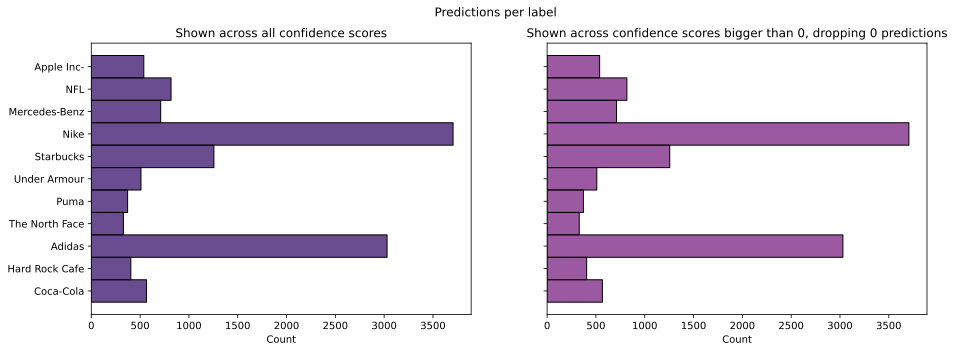

In [131]:
confidence = 0
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
fig.suptitle("Predictions per label")


sns.histplot(y=test_pred['true_label_name'],
            color=palette[5],
             ax=axes[0])
axes[0].set_ylabel('')
axes[0].set_xlabel('Count')
axes[0].set_title('Shown across all confidence scores')

sns.histplot(y=test_pred.loc[test_pred['list_conf']>=confidence,'true_label_name'],
            color=palette[10],
             ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('Count')
drop=len(test_pred)-len(test_pred[test_pred['list_conf']>=confidence])
axes[1].set_title(f'Shown across confidence scores bigger than {confidence}, dropping {drop} predictions')
axes[1].set_visible(True)

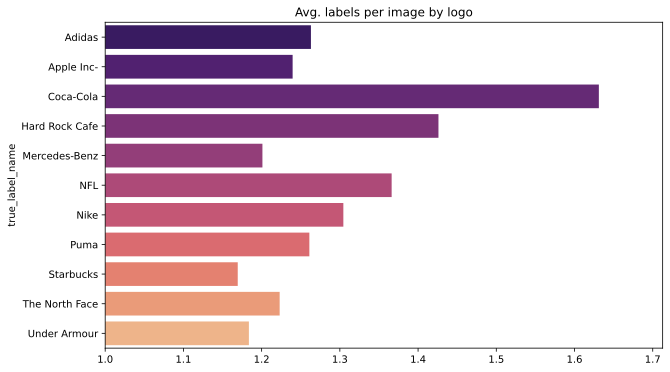

In [132]:
"""
Plot of avg logos per image by different classes
"""

imcount_by_class = test_pred.groupby(["picture","true_label_name"]).size().groupby("true_label_name").size()
boxcount_by_class = test_pred.groupby("true_label_name").size()
ratio = boxcount_by_class/imcount_by_class
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x =ratio.values,y = ratio.index, ax = ax, palette = palette[5::2])

ax.set_xlim(1)
ax.set_title("Avg. labels per image by logo")
plt.show()

Plot overall confidence distribution on all predicitons 

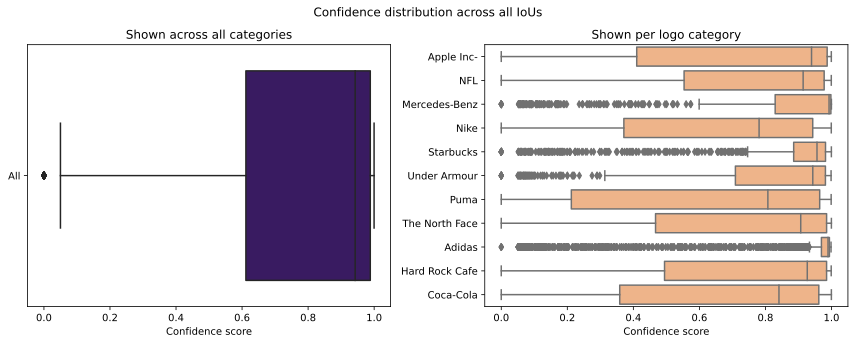

In [133]:


fig, axes = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle("Confidence distribution across all IoUs")

sns.boxplot(y=['All']*len(test_pred.loc[test_pred['list_conf']>=confidence,'true_label']),
            x=test_pred.loc[test_pred['list_conf']>=confidence,'list_conf'], color=palette[5],ax=axes[0])
axes[0].set_ylabel('')
axes[0].set_xlabel('Confidence score')
axes[0].set_title('Shown across all categories')

sns.boxplot(y='true_label_name',x='list_conf',data=test_pred[test_pred['list_conf']>=confidence], color=palette[-5],ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('Confidence score')
axes[1].set_title('Shown per logo category')
axes[1].set_visible(True)

fig.tight_layout(rect = [0,0.03,1,0.95])

Now lets look at confidence distribution across different levels of IoU

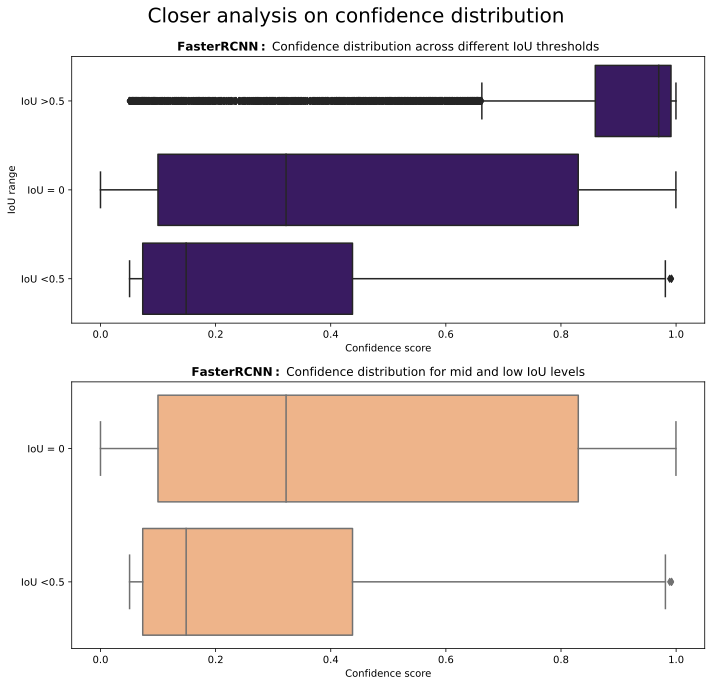

In [134]:
fig, axes = plt.subplots(2, 1, figsize=(10,10))
fig.suptitle("Closer analysis on confidence distribution",fontsize = 20)

sns.boxplot(y=test_pred['iou_range'],x=test_pred['list_conf'], color=palette[5],ax=axes[0])
axes[0].set_ylabel('IoU range')
axes[0].set_xlabel('Confidence score')
axes[0].set_title(r"$\bf{FasterRCNN:}$ Confidence distribution across different IoU thresholds")

sns.boxplot(y=test_pred.loc[test_pred['iou_range']!='IoU >0.5',"iou_range"],x=test_pred.loc[test_pred['iou_range']!='IoU >0.5',"list_conf"], color=palette[-5],ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('Confidence score')
axes[1].set_title(r"$\bf{FasterRCNN:}$ Confidence distribution for mid and low IoU levels")


axes[0].set_visible(True)

fig.tight_layout(rect = [0,0.03,1,0.95])



In [135]:
"""
Get lower quartile of mid category 
"""

mid = test_pred.loc[test_pred['iou_range']=='IoU <0.5',"list_conf"]
print(f"Lower quantile of mid Iou range confidences: {round(mid.quantile(0.25)*100,3)}%")

Lower quantile of mid Iou range confidences: 7.338%


Analysis on average number of predicted bounding boxes per image

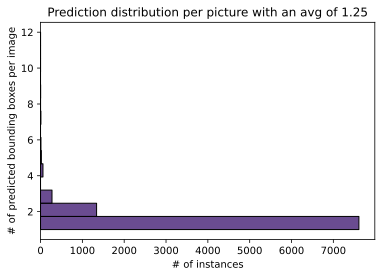

In [136]:
confidence = np.round(mid.quantile(0.25),4)
stats=pd.DataFrame(test_pred[test_pred['list_conf']>=confidence].groupby('picture')['pred_bounding'].count())
avg_bb_image=stats['pred_bounding'].mean()
ax=sns.histplot(y=stats['pred_bounding'],color=palette[5])
ax.set_title(f'Prediction distribution per picture with an avg of {np.round(avg_bb_image,2)}')
ax.set_ylabel('# of predicted bounding boxes per image')
ax.set_xlabel('# of instances')
ax.set_visible(True)

## Analysis on labels with high confidence but 0 IoU

In [137]:
"""
Create dataframe of images with 0 IoU but confidence higher than itial threshold
"""
pictures_investigate = test_pred.loc[(test_pred['list_conf']>=confidence) & (test_pred['list_iou']==0), :].reset_index(drop=True)
print("Number of pictures to investigate: ",len(pictures_investigate['picture'].unique()))
pictures_investigate.head()

Number of pictures to investigate:  1658


true_bounding  pred_label  ...  aspect_ratio_true  pred_label_name
0  [349.0, 396.0, 435.5, 479.0]           6  ...           0.959538        Starbucks
1  [349.0, 396.0, 435.5, 479.0]           8  ...           0.959538    Mercedes-Benz
2  [364.0, 451.0, 433.5, 521.5]           8  ...           1.014388    Mercedes-Benz
3  [364.0, 451.0, 433.5, 521.5]           8  ...           1.014388    Mercedes-Benz
4  [363.0, 521.0, 446.0, 616.0]           6  ...           1.144578        Starbucks

[5 rows x 15 columns]

Image 0, Label: Coca-Cola
Image 0, Label: Coca-Cola
Image 1, Label: Coca-Cola
Image 1, Label: Coca-Cola
Image 1, Label: Coca-Cola
Image 2, Label: Coca-Cola
Image 2, Label: Coca-Cola


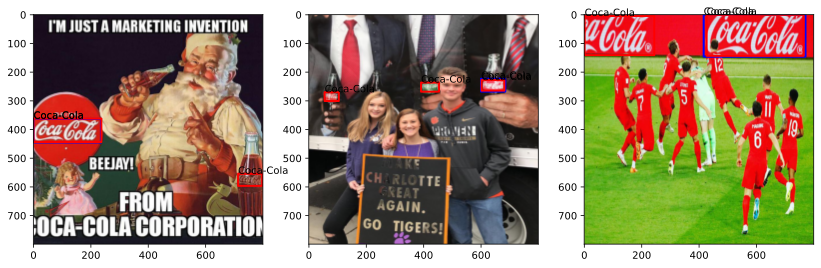

In [138]:
"""
Lets plot the bounding boxes of those images to understand roughly the percentage of bad predictions in there
"""
show_bbox(test_pic_path, pictures_investigate, test_pred, n_show=3, start=-1)

In [139]:
"Manually go through 63 images to understand the fraction of bad logos compared to the total"

bad_logos = [
            1,0,1,1,0,0,1,1,0,0,1,1,2,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
]

total_logos = [
          2,2,2,2,3,2,3,2,3,2,3,3,2,2,1,2,1,6,2,3,2,2,2,2,2,3,2,3,2,2,2,2,3,2,3,2,2,2,4,2,0,2,2,2,2,2,2,2,3,2,3,2,2,2,2,2,1,3,2,2,4,3,2
]

print(len(bad_logos))
print(len(total_logos))

63
63


In [140]:
print(f"Fraction of incorrectly labelled images above threshold lambda:  {np.round(sum(bad_logos)/sum(total_logos),3)*100}%")

Fraction of incorrectly labelled images above threshold lambda:  13.3%


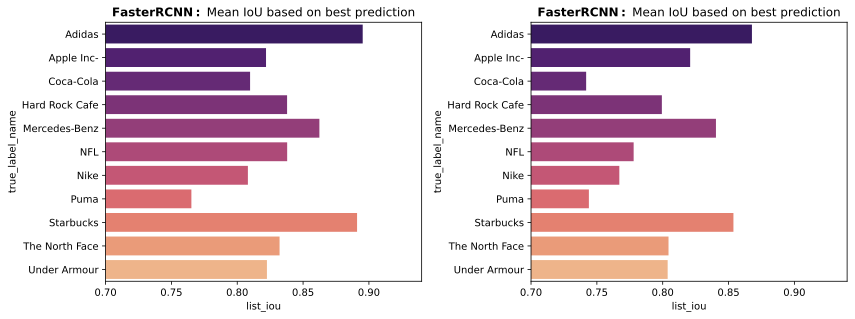

In [141]:
"""
Barplot of mean IoU per class
"""
fig, axs = plt.subplots(1,2,figsize = (12,5),sharex = True)


ax = axs[0]
max_IoU = calculate_results_maxIoU(test_pred, confidence).reset_index(drop = False)
sns.barplot(y = max_IoU["true_label_name"],x = max_IoU["list_iou"], ax = ax, palette = palette[5::2])
ax.set_title(r"$\bf{FasterRCNN:}$ Mean IoU based on best prediction")
ax.set_xlim(0.7,)


ax = axs[1]
max_Conf = calculate_results_maxConfidence(test_pred, confidence = 0).reset_index(drop = False)
sns.barplot(y = max_Conf["true_label_name"],x = max_Conf["list_iou"], ax = ax, palette = palette[5::2])
ax.set_title(r"$\bf{FasterRCNN:}$ Mean IoU based on best prediction")
ax.set_xlim(0.7,)

fig.tight_layout(rect = [0,0.03,1,0.95])

In [142]:
"""
The scores above as table by max IoU
"""
max_IoU

true_label_name  list_iou
0           Adidas  0.895285
1       Apple Inc-  0.821862
2        Coca-Cola  0.809756
3   Hard Rock Cafe  0.837854
4    Mercedes-Benz  0.862386
5              NFL  0.837917
6             Nike  0.808090
7             Puma  0.765179
8        Starbucks  0.891005
9   The North Face  0.832149
10    Under Armour  0.822552

In [143]:
"""
The scores above as table by max Confidence
"""
max_Conf

true_label_name  list_iou
0           Adidas  0.867762
1       Apple Inc-  0.820849
2        Coca-Cola  0.741862
3   Hard Rock Cafe  0.799358
4    Mercedes-Benz  0.840439
5              NFL  0.777935
6             Nike  0.767054
7             Puma  0.743938
8        Starbucks  0.853712
9   The North Face  0.804415
10    Under Armour  0.803767

Text(0.5, 1.0, 'Confidence for well predicting boxes per logo category')

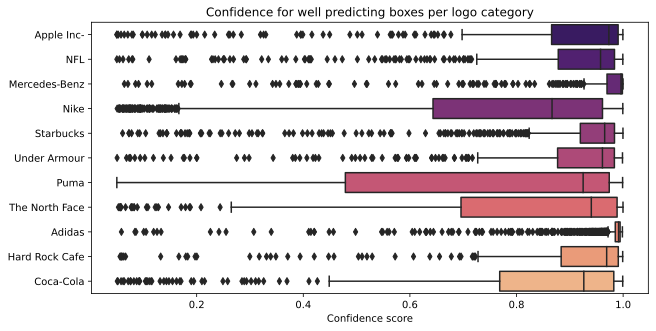

In [144]:

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(y=test_pred.loc[test_pred['iou_range']=='IoU >0.5','true_label_name'],x=test_pred.loc[test_pred['iou_range']=='IoU >0.5','list_conf'], palette=palette[5::2],ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Confidence score')
ax.set_title('Confidence for well predicting boxes per logo category')


#### Analysis of logos with higher confidence than best predicted

In [101]:
"""
Print the bounding boxes that are better than the best fitting bounding box based on IoU

"""

#gets the best prediction based on IoU
best = test_pred.loc[test_pred.groupby(by = "picture")["list_iou"].idxmax().values,["picture", "list_conf"]].rename({"picture" : "path", "list_conf": "best_conf"},axis = 1)

#Merge back to all predictions to check if the best confidence better than the confidence of that prediction
higher_conf = pd.merge(test_pred,best,left_on = "picture", right_on = "path", how = "left")
higher_conf_with_best = higher_conf.loc[higher_conf["best_conf"] <= higher_conf["list_conf"]]
higher_conf = higher_conf.loc[higher_conf["best_conf"] < higher_conf["list_conf"]]

#Plot n images
n = 3
print(f"Number of pictures where best confidence is not the one with best IoU: {higher_conf.picture.unique().shape[0]} and {len(higher_conf)} predictions")

Number of pictures where best confidence is not the one with best IoU: 468 and 577 predictions


Image 0, Label: Adidas
Image 0, Label: Adidas
Image 1, Label: Adidas
Image 1, Label: Adidas
Image 2, Label: Adidas
Image 2, Label: Adidas
Image 3, Label: Adidas
Image 3, Label: Adidas
Image 4, Label: Adidas
Image 4, Label: Adidas
Image 4, Label: Adidas
Image 4, Label: Adidas
Image 5, Label: Adidas
Image 5, Label: Adidas


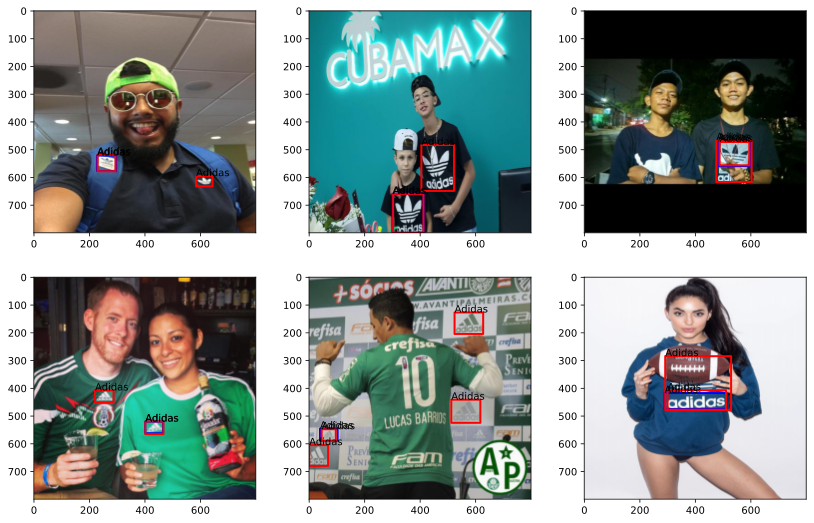

In [153]:
show_bbox(test_pic_path, higher_conf, higher_conf_with_best, n_show=6, start=-1)

In [103]:
good_logos = [
              0,1,3,1,1,1,1,1,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,3,1,1,1,1,1,0,0,1,2,0,1,0,0,1,1,0,2,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,1,0,1,1,1,1,2,2,1,0,1,1,
              1,1,1,1,1,1,1,1,1,1,1,1,1,0,2,0,1,1,4,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,0,1,0,1,2,1,1,0,3,2,1,1,0,1,1,2,1,0,1,1,1,1,0,0,1,1,1,2,1,1,2,1,1,
              0,1,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1,0,0,0,0,2,1,1,0,0,0,0,1,1,1,1,1,2,1,1,1,1,2,1,1,1,1,1,1,0,1,0,2,2,1,1,2,1,1,0,0,0,1,1,1,
              1,1,2,1,1,1,1,1,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,3,0,1,1,1,0,2,1,0,1,1,1,1,1,1,1,1,4,1,1,1,1,1,1,1,0,2,1,1,2,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,1,
              1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,3,1,1,1,1,2,1,1,1,1,1,1,1,6,1,1,1,1,1,1,0,1,3,0,3,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,3,7,1,1,1,1,1,1,1,2,1,3,1,1,1,1,1,2,1,1,1,1,2,1,
              1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,2,1,1,1,1,1,2,2,3,0,1,0,1,2,1,1,0,1,8,2,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,1,1,1,1,2,2,0,1,0,1,0,1
]
all_logos = [
             1,1,3,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,2,2,1,0,1,1,
             1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,0,1,0,1,2,1,1,0,3,2,1,1,0,1,1,2,1,2,1,1,1,1,0,0,1,1,1,2,1,1,2,1,1,
             0,1,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,2,0,1,0,0,1,1,2,1,1,2,1,1,0,1,1,1,1,1,2,1,1,1,1,2,1,1,2,1,1,1,0,1,0,2,2,1,1,2,1,1,0,0,0,1,1,1,
             1,1,2,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,1,3,0,1,1,1,0,2,1,0,1,1,1,1,1,1,1,1,4,1,1,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,
             1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,3,1,1,1,1,2,1,1,1,1,1,1,1,6,1,1,1,1,1,1,1,1,3,1,3,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,3,7,1,1,1,1,1,1,1,2,1,3,1,1,1,1,1,2,1,1,1,1,2,1,
             1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,2,1,1,1,1,1,2,2,3,1,1,1,1,2,1,1,0,1,9,2,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,2,1,1,1,2,2,0,1,1,1,0,1
]


print(len(good_logos))
print(len(all_logos))

468
468


In [104]:
sum(good_logos)/sum(all_logos)

0.9119373776908023

#### Classification Performance

In [105]:
"""
Get label strings in a list correctly sorted
"""
l = list(int2str.items())
l = ["No Value"] + [v for k,v in sorted(l,key = lambda x: x[0])]

In [150]:
from sklearn.metrics import confusion_matrix,accuracy_score
"""
Plots confusion matrix of the predicted vs true labels
"""
def confusionMatrixPlot(y,y_hat,score = accuracy_score):
    confusionMatrix = confusion_matrix(y,y_hat)
    fig, ax = plt.subplots(figsize = (14,7))
    sns.heatmap(confusionMatrix,annot=True, fmt=".0f", linewidths=.5, square = True, cmap = palette[27:10:-1],ax = ax)
    ax.set_ylabel('Actual label');
    ax.set_xlabel('Predicted label');
    ax.set_xticklabels(l,rotation = 70, horizontalalignment = "right")
    ax.set_yticklabels(l,rotation = 0)
    all_sample_title = r"$\bf{FasterRCNN:}$" + f'Accuracy Score:{np.round(score(y,y_hat),5)}'
    ax.set_title(all_sample_title, size = 15);

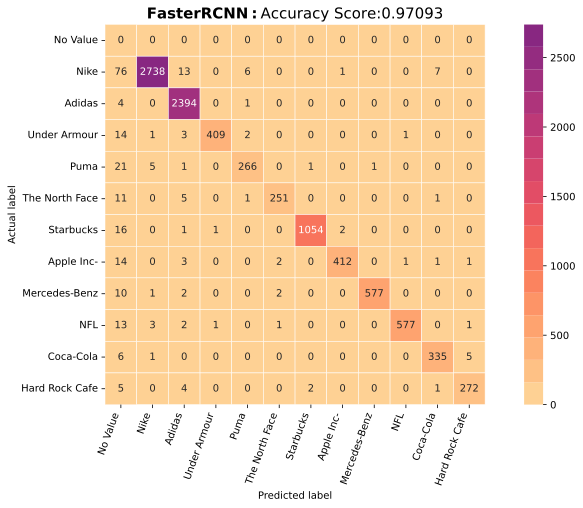

In [151]:
best = test_pred.loc[test_pred.groupby(by = "picture")["list_iou"].idxmax().values]

confusionMatrixPlot(best["true_label"], best["pred_label"])

### Further investigation for understanding any particular oddities among the bad predictions

In [108]:
"""
Analysis of the bounding box ratio and aspect ratio distribution across the low and high IoU groups
"""
test_pred["bbox_ratio"] = test_pred["area_true"] / (800*800)
no_zeros_df = test_pred.loc[(test_pred["list_iou"] > 0) &(test_pred["list_conf"] > 0.074)] 
no_zeros_df

true_bounding  pred_label  ...  pred_label_name  bbox_ratio
0      [347.0, 577.0, 400.5, 644.5]           7  ...       Apple Inc-    0.005643
1      [734.0, 510.0, 800.0, 600.5]           9  ...              NFL    0.009333
3      [709.0, 612.0, 769.5, 689.0]           7  ...       Apple Inc-    0.007279
4      [298.0, 118.0, 363.0, 195.5]           9  ...              NFL    0.007871
8      [349.0, 396.0, 435.5, 479.0]           8  ...    Mercedes-Benz    0.011218
...                             ...         ...  ...              ...         ...
13293  [465.0, 494.0, 556.0, 546.0]          11  ...   Hard Rock Cafe    0.007394
13295  [647.0, 374.0, 709.0, 423.5]          10  ...        Coca-Cola    0.004795
13297  [370.0, 182.0, 600.5, 294.5]          10  ...        Coca-Cola    0.040518
13299   [624.0, 74.0, 726.0, 157.5]          11  ...   Hard Rock Cafe    0.013308
13300  [186.0, 362.0, 265.0, 407.0]          10  ...        Coca-Cola    0.005555

[9397 rows x 16 columns]

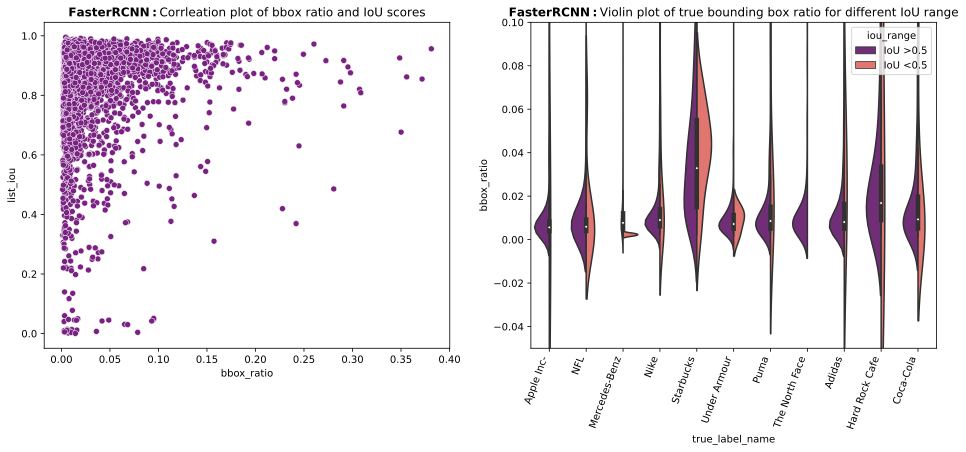

In [109]:
fig, axs = plt.subplots(1,2,figsize = (16,6))

ax = axs[1]
sns.violinplot(x = no_zeros_df["true_label_name"],y = no_zeros_df["bbox_ratio"], hue = no_zeros_df["iou_range"], split = True,ax = ax, palette = palette[10:21:10])
ax.set_title(r"$\bf{FasterRCNN:}$" + "Violin plot of true bounding box ratio for different IoU range")
ax.set_xticklabels(no_zeros_df["true_label_name"].unique(),rotation = 70, horizontalalignment = "right")
ax.set_ylim(-0.05,0.1)

ax = axs[0]
sns.scatterplot(x = no_zeros_df["bbox_ratio"],y =  no_zeros_df["list_iou"],ax = ax, color = palette[10])
ax.set_title(r"$\bf{FasterRCNN:}$" + "Corrleation plot of bbox ratio and IoU scores")

plt.show()

Overall statistics on the labels under investigation

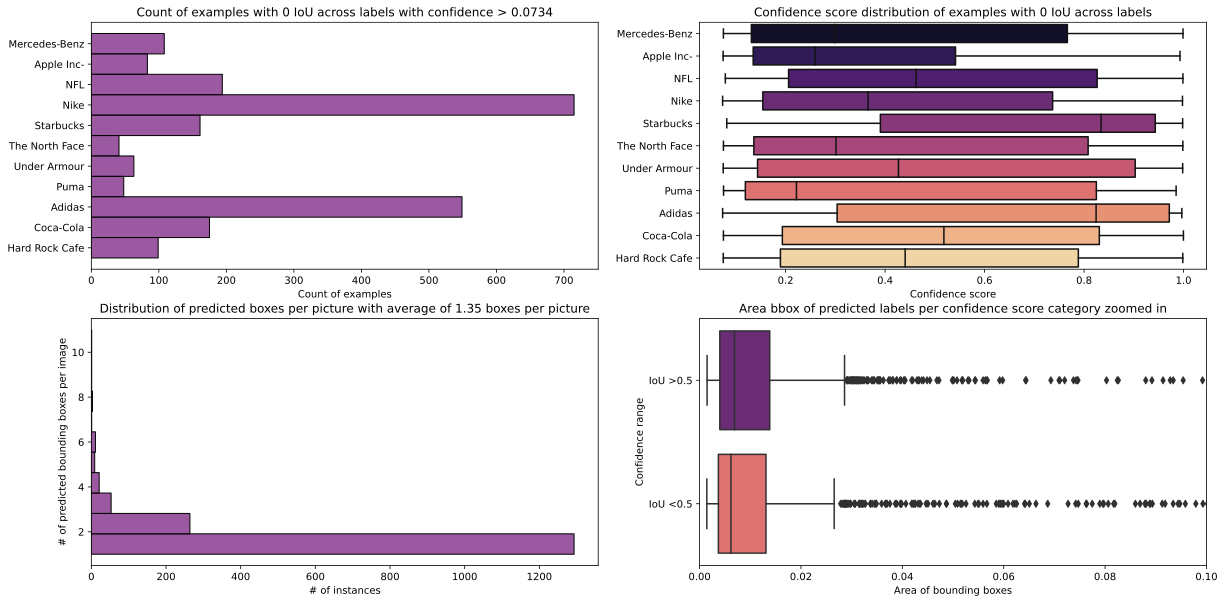

In [110]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))


sns.histplot(y=pictures_investigate['true_label_name'], color=palette[10],bins=11, ax=axes[0,0])
axes[0,0].set_title(f'Count of examples with 0 IoU across labels with confidence > {confidence}')
axes[0,0].set_xlabel('Count of examples')
axes[0,0].set_ylabel('')

stats = pictures_investigate.loc[pictures_investigate['list_conf']>=confidence]
sns.boxplot(y= stats['true_label_name'], x=stats['list_conf'], palette=p_name, ax=axes[0,1])
axes[0,1].set_title(f'Confidence score distribution of examples with 0 IoU across labels')
axes[0,1].set_xlabel('Confidence score')
axes[0,1].set_ylabel('')

stats=pictures_investigate[pictures_investigate['list_conf']>=confidence].groupby('picture',as_index = False)['pred_bounding'].count()
avg_bb_image=stats['pred_bounding'].mean()
sns.histplot(y=stats['pred_bounding'], color=palette[10],bins=11, ax=axes[1,0])
axes[1,0].set_title(f'Distribution of predicted boxes per picture with average of {np.round(avg_bb_image,2)} boxes per picture')
axes[1,0].set_xlabel('# of instances')
axes[1,0].set_ylabel('# of predicted bounding boxes per image')

investigate_area=pictures_investigate.loc[pictures_investigate['list_conf']>=confidence,['area_predicted','true_label_name','iou_range','confidence_range']]
investigate_area['area_predicted'] = investigate_area['area_predicted'] / scale

sns.boxplot(x='area_predicted', y='confidence_range', 
            data=investigate_area, 
            ax=axes[1,1], palette=p_name)
axes[1,1].set_title('Area bbox of predicted labels per confidence score category zoomed in')
axes[1,1].set_ylabel('Confidence range')
axes[1,1].set_xlabel('Area of bounding boxes')
axes[1,1].set_xlim(left=0, right=0.1)

axes[1,1].set_visible(True)

Investigating whether there might be differences between the labels under investigation and the true labels associated to the respective pictures

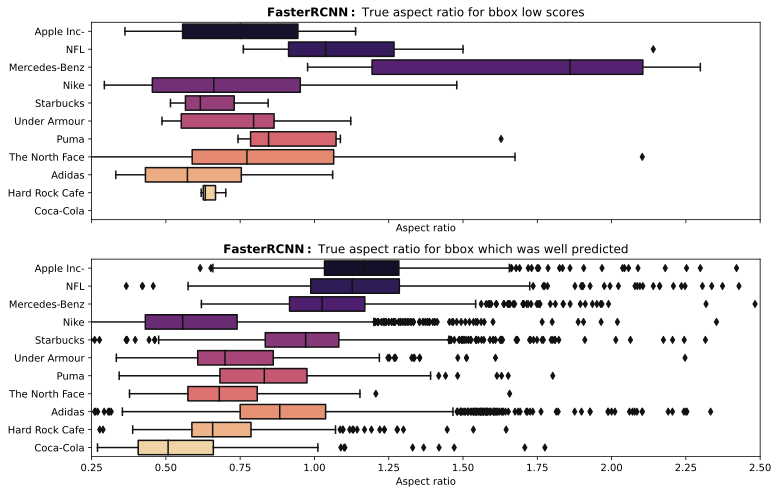

In [111]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharey=True, sharex=True)
sns.boxplot(x=no_zeros_df.loc[no_zeros_df["iou_range"] == "IoU <0.5", 'aspect_ratio_true'], y=no_zeros_df.loc[no_zeros_df["iou_range"] == "IoU <0.5",'true_label_name'], ax=ax[0],palette=p_name)
ax[0].set_title(r"$\bf{FasterRCNN:}$" +' True aspect ratio for bbox low scores')
ax[0].set_ylabel("")
ax[0].set_xlabel("Aspect ratio")


sns.boxplot(x=no_zeros_df.loc[no_zeros_df["iou_range"] != "IoU <0.5", 'aspect_ratio_true'], y=no_zeros_df.loc[no_zeros_df["iou_range"] != "IoU <0.5",'true_label_name'], ax=ax[1], palette=p_name)
ax[1].set_title(r"$\bf{FasterRCNN:}$" +' True aspect ratio for bbox which was well predicted')
ax[1].set_ylabel("")
ax[1].set_xlabel("Aspect ratio")
ax[1].set_xlim(0.25,2.5)
ax[1].set_visible(True)

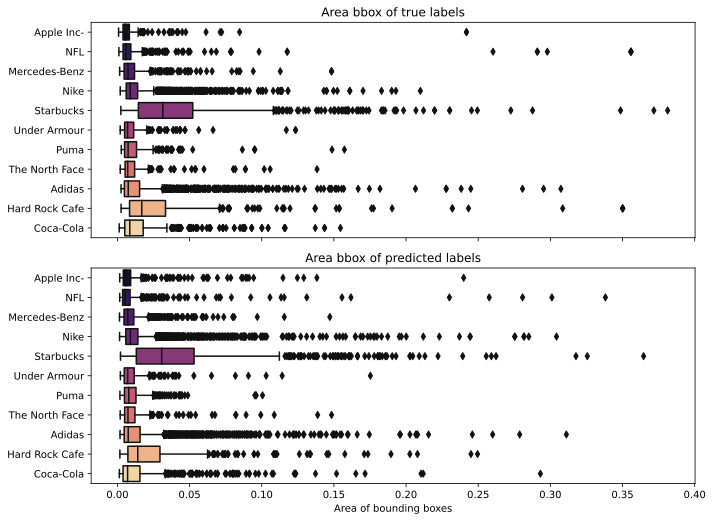

In [112]:
"""
BBox area distribution for true and predicted labels - Checks if any difference in predictions of bboxes vs true
"""

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)

investigate_area_true=test_pred.loc[test_pred['list_conf']>=confidence,['area_true','true_label_name','iou_range','confidence_range']]
investigate_area_true['area_true'] = investigate_area_true['area_true'] / scale

sns.boxplot(x='area_true', y='true_label_name', 
            data=investigate_area_true, ax=ax[0], palette=p_name)
ax[0].set_title('Area bbox of true labels')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
investigate_area=test_pred.loc[test_pred['list_conf']>=confidence,['area_predicted','true_label_name','iou_range','confidence_range']]
investigate_area['area_predicted'] = investigate_area['area_predicted'] / scale

sns.boxplot(x='area_predicted', y='true_label_name', 
            data=investigate_area, ax=ax[1], palette=p_name)
ax[1].set_title('Area bbox of predicted labels')
ax[1].set_ylabel('')
ax[1].set_xlabel('Area of bounding boxes')


ax[1].set_visible(True)
fig.tight_layout(rect = [0,0.03,1,0.95])

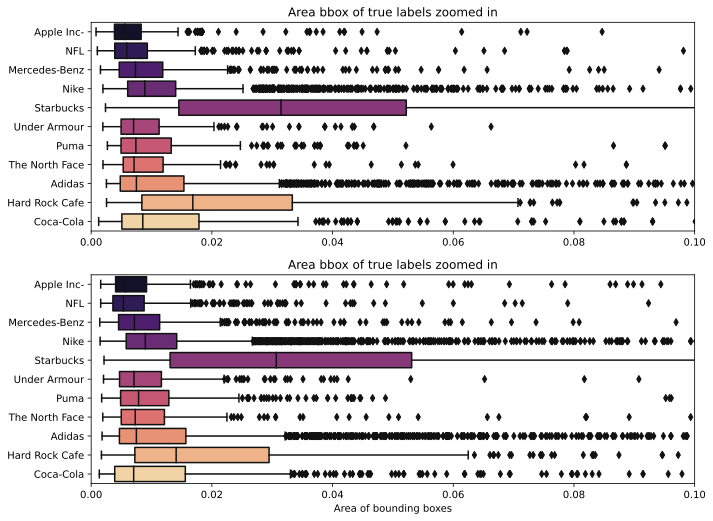

In [113]:
"""
Too many outlier, lets zoom in
"""

zoom=0.1
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharey=True)
sns.boxplot(x='area_true', y='true_label_name', 
            data=investigate_area_true, ax=ax[0], palette=p_name)
ax[0].set_title('Area bbox of true labels zoomed in')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xlim(left=0,right=zoom)


sns.boxplot(x='area_predicted', y='true_label_name', 
            data=investigate_area, ax=ax[1], palette=p_name)
ax[1].set_title('Area bbox of true labels zoomed in')
ax[1].set_ylabel('')
ax[1].set_xlabel('Area of bounding boxes')
ax[1].set_xlim(left=0, right=zoom)

ax[1].set_visible(True)

fig.tight_layout(rect = [0,0.03,1,0.95])

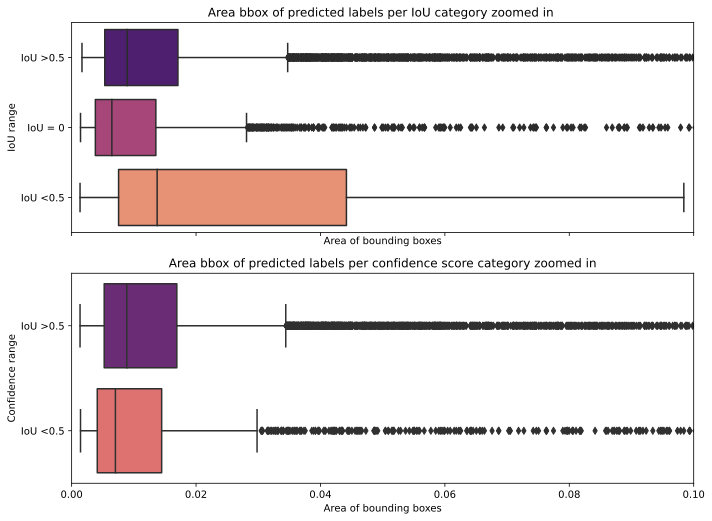

In [114]:
zoom=0.1
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

sns.boxplot(x='area_predicted', y='iou_range', 
            data=investigate_area, ax=ax[0], palette=p_name)
ax[0].set_title('Area bbox of predicted labels per IoU category zoomed in ')
ax[0].set_ylabel('IoU range')
ax[0].set_xlabel('Area of bounding boxes')
ax[0].set_xlim(left=0,right=zoom)


sns.boxplot(x='area_predicted', y='confidence_range', 
            data=investigate_area, ax=ax[1], palette=p_name)
ax[1].set_title('Area bbox of predicted labels per confidence score category zoomed in')
ax[1].set_ylabel('Confidence range')
ax[1].set_xlabel('Area of bounding boxes')
ax[1].set_xlim(left=0, right=zoom)

ax[1].set_visible(True)

fig.tight_layout(rect = [0,0.03,1,0.95])